In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 

In [2]:
import warnings 
warnings.filterwarnings('ignore')

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 06: Redes neurais

**1.** O código abaixo baixa e carrega o banco de dados CIFAR10, que contém diversas imagens RGB de 10 classes distintas. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação. Também provemos um exemplo de como definir um modelo em pytorch (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação. Consulte a documentação do pytorch para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado. Além disso, mostre como os dados de entrada são transformados ao longo das camadas (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
batch_size = 512 

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

trains_set, validation_set = random_split(train_set, [0.75, 0.25])

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
validation_loader = DataLoader(
    validation_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i]/2 + 0.5
    npimg = npimg.numpy()
    ax[i%2,i//2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i%2,i//2].set_title(classes[labels[i]])

plt.tight_layout()

cuda:0
Files already downloaded and verified
Files already downloaded and verified


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.LazyLinear(120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.001)

# from the pytorch documentation
for epoch in range(15):
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_cnn.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

def accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = cnn(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

print('Acc:', accuracy(loader = test_loader))

def errorValidation(loader):
        criterion = nn.CrossEntropyLoss()
        loss = 0
        with torch.no_grad():
            for data in loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = cnn(inputs)
                loss += criterion(outputs, labels).item()
        # gets the average loss
        return loss/len(loader)

print('Error with respect to validation set:', errorValidation(loader = validation_loader))

Acc: 0.5625
Error with respect to validation set: 1.140804362297058


Observado o treinamento da rede neural convolucional acima, vamos definir uma nova classe para variarmos os hiperparâmetros e encontrarmos o melhor conjunto de hiperparâmetros em relação ao erro de validação.  Não há grandes novidades em relação à classe anterior: apenas dou margem para que os parâmetros variem. Além disso, defino o método para cálculo da acurácia (em relação ao conjunto de teste) e outro para calcular a perda (em relação ao conjunto de validação).

In [134]:
class VariantCNN(nn.Module):
    def __init__(self, outChannels1, outChannels2, kernelSize, poolKernelSize, poolStride, outSizeLazy, outSizeLinear2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, outChannels1, kernelSize)
        self.pool = nn.MaxPool2d(poolKernelSize, poolStride)
        self.conv2 = nn.Conv2d(outChannels1, outChannels2, kernelSize)
        self.fc1 = nn.LazyLinear(outSizeLazy)
        self.fc2 = nn.Linear(outSizeLazy, outSizeLinear2)
        self.fc3 = nn.Linear(outSizeLinear2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def accuracy(self):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct/total

    def errorValidation(self):
        criterion = nn.CrossEntropyLoss()
        loss = 0
        with torch.no_grad():
            for data in validation_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = self(inputs)
                loss += criterion(outputs, labels).item()
        return loss/len(validation_loader)

Dadas as *constraints* de tempo e hardware, os hiperparâmetros possíveis foram definidos manualmente, com base em estudos anteriores. Naturalmente, poderíamos aleatorizar dentro de um range que fizesse sentido. 

Além disso, optou-se por variar apenas alguns dos hiperparâmetros. Abordagens mais sofisticadas poderiam variar outros hiperparâmetros que não estão no escopo deste desenvolvimento --- por exemplo, o número de camadas convolucionais, o número de camadas lineares e/ou o tamanho dos batches. 

Para os testes a seguir, é importante comentar, o tamanho dos batches foi alterado de 2048 para 512, por uma percepção particular, dados os testes ao longo do desenvolvimento do trabalho, de que o modelo alcançaria melhor desempenho com este tamanho de batch. Em todo caso, a abordagem adotada testa uma quantidade razoável de combinações de hiperparâmetros.

In [59]:
# definimos listas com dois valores possiveis para cada hiperparametro
outChannels1s = [6, 12]
outChannels2 = [16, 32]
outSizesLazy = [120, 240]
outSizesLinear2 = [84, 168]
kernelSizes = [3, 5]
poolKernelSizes = [2, 3]
poolStrides = [2, 3]

In [ ]:
# writes each combination, accuracy and validation error in a file
with open('results.csv', 'w') as f:
    # add header to file
    f.write('outChannel1,outChannel2,kernelSize,poolKernelSize,poolStride,outSizeLazy,outSizeLinear2,error\n')
    for outChannel1 in outChannels1s:
            for outChannel2 in outChannels2:
                for outSizeLazy in outSizesLazy:
                    for outSizeLinear2 in outSizesLinear2:
                        for kernelSize in kernelSizes:
                            for poolStride in poolStrides:
                                for poolKernelSize in poolKernelSizes:
                                    variantCNN = VariantCNN(outChannel1, outChannel2, kernelSize, poolKernelSize, poolStride, outSizeLazy, outSizeLinear2).to(device)  
                                    criterion = nn.CrossEntropyLoss()
                                    optimizer_variantCNN = torch.optim.Adam(variantCNN.parameters(), lr=0.001)
                                    for epoch in range(15):
                                        for data in train_loader:
                                            inputs, labels = data[0].to(device), data[1].to(device)
                                            optimizer_variantCNN.zero_grad()
                                            outputs = variantCNN(inputs)
                                            loss = criterion(outputs, labels)
                                            loss.backward()
                                            optimizer_variantCNN.step()
                                    error = variantCNN.errorValidation()
                                    print(f'Loss: {error}')
                                    f.write(str(outChannel1) + ',' + str(outChannel2) + ',' + str(kernelSize) + ',' + str(poolKernelSize) + ',' + str(poolStride) + ',' + str(outSizeLazy) + ',' + str(outSizeLinear2) + ',' + str(error) + '\n')

# o output dessa célula foi apagado para evitar que o pdf ficasse muito grande

In [135]:
import pandas as pd
results = pd.read_csv('results.csv')

In [136]:
# get the row with the lowest error
best = results.loc[results['error'].idxmin()]
print('Best combination:\n',best)

Best combination:
 outChannel1        12.000000
outChannel2        32.000000
kernelSize          3.000000
poolKernelSize      2.000000
poolStride          2.000000
outSizeLazy       240.000000
outSizeLinear2    168.000000
error               0.648468
Name: 120, dtype: float64


In [137]:
listBest = best.tolist()
outChannel1 = int(listBest[0])
outChannel2 = int(listBest[1])
kernelSize = int(listBest[2])
poolKernelSize = int(listBest[3])
poolStride = int(listBest[4])
outSizeLazy = int(listBest[5])
outSizeLinear2 = int(listBest[6])

# train the model with the best combination
variantCNN = VariantCNN(outChannel1, outChannel2, kernelSize, poolKernelSize, poolStride, outSizeLazy, outSizeLinear2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_variantCNN = torch.optim.Adam(variantCNN.parameters(), lr=0.001)

losses = []
for epoch in range(15):
    loss_epoch = 0
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_variantCNN.zero_grad()
        outputs = variantCNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_variantCNN.step()
    # computes the average loss/epoch in the test set
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = variantCNN(inputs)
        loss_epoch += criterion(outputs, labels).item()
    losses.append(loss_epoch/len(test_loader))

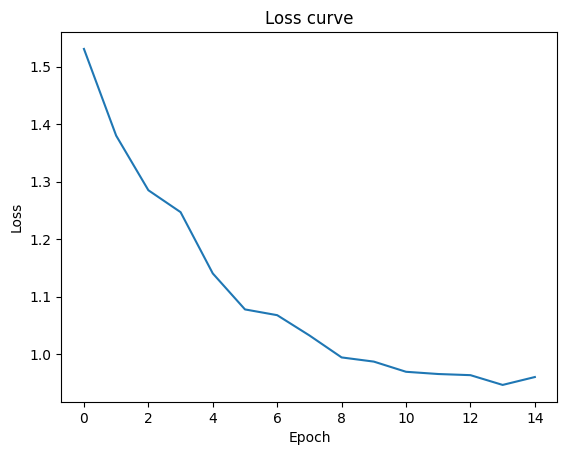

In [138]:
# plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.show()

Observe que a curva de perda em relação ao conjunto de validação indica, de fato, queda da perda ao longo do treinamento. A acurácia, computada abaixo, não é a ideal, mas é razoável, dado o tempo de treinamento e a quantidade de hiperparâmetros testados. A variação de outros hiperparâmetros, como o número de camadas convolucionais, poderia surtir efeito na acurácia do modelo.

In [139]:
# gets the accuracy in the test set
print('Accuracy in the test set:', variantCNN.accuracy())

Accuracy in the test set: 0.68


Para obter os resultados a cada camada, podemos ajustar a classe, em particular o método `forward`, para que ela guarde os resultados a cada camada:

In [140]:
class VariantCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, outChannel1, kernelSize)
        self.pool = nn.MaxPool2d(poolKernelSize, poolStride)
        self.conv2 = nn.Conv2d(outChannel1, outChannel2, kernelSize)
        self.fc1 = nn.LazyLinear(outSizeLazy)
        self.fc2 = nn.Linear(outSizeLazy, outSizeLinear2)
        self.fc3 = nn.Linear(outSizeLinear2, 10)

    # x is the input image, pics is a list with the images after each layer
    def forward(self, x):
        pics = []
        x = self.conv1(x)
        pics.append(x)
        x = self.pool(F.relu(x))
        pics.append(x)
        x = self.conv2(x)
        pics.append(x)
        x = self.pool(F.relu(x))
        pics.append(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        pics.append(x)
        x = F.relu(self.fc2(x))
        pics.append(x)
        x = self.fc3(x)
        pics.append(x)
        return x, pics

# train the model with the best combination
variantCNN = VariantCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_variantCNN = torch.optim.Adam(variantCNN.parameters(), lr=0.001)

for epoch in range(15):
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_variantCNN.zero_grad()
        outputs, pics = variantCNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_variantCNN.step()

Agora, vamos plotar os resultados em alguns exemplos de imagem:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


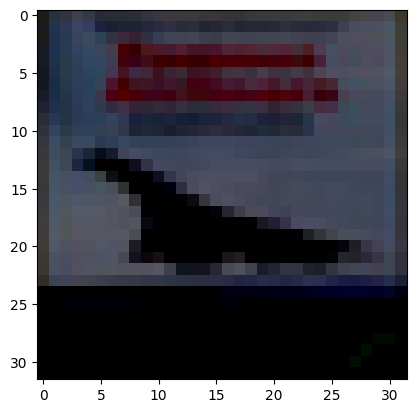

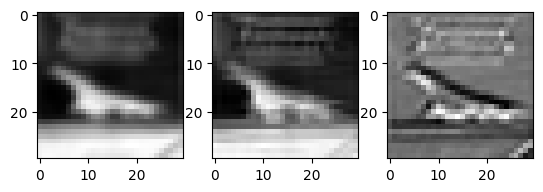

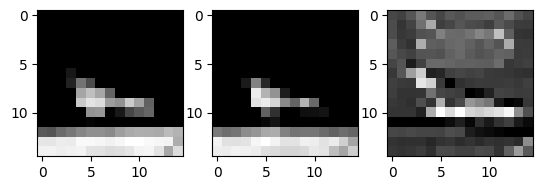

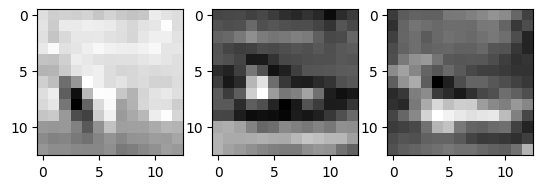

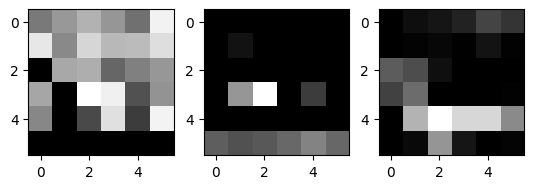

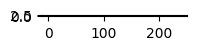

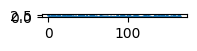

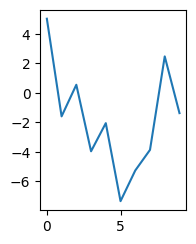

In [141]:
image_tensor = test_set[3][0]
image = image_tensor.unsqueeze(0)
image = image[0]/2 
image = np.transpose(image.numpy(), (1, 2, 0))
plt.imshow(image)
plt.show()

# gets the pics after each layer
_, pics = variantCNN(image_tensor.unsqueeze(0).to(device))

# plot the pics
for i, pics in enumerate(pics):
    try:
        for j in range(3):
            plt.subplot(1, 3, j+1)
            plt.imshow(pics[0, j].cpu().detach().numpy(), cmap='gray')
        plt.show()
    except:
        plt.plot(pics[0].cpu().detach().numpy())
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


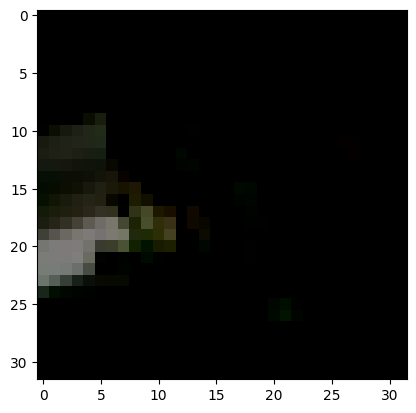

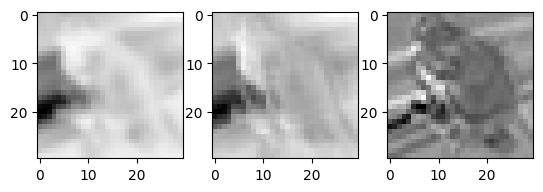

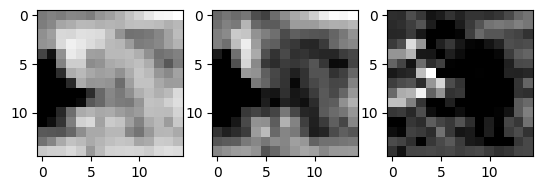

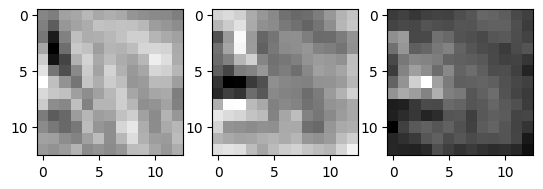

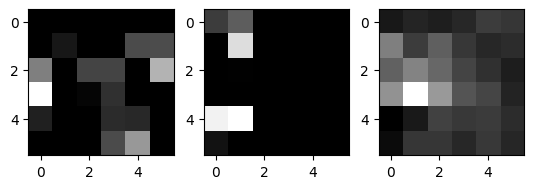

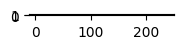

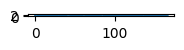

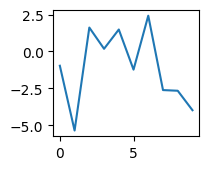

In [142]:
image_tensor = test_set[7][0]
image = image_tensor.unsqueeze(0)
image = image[0]/2 
image = np.transpose(image.numpy(), (1, 2, 0))
plt.imshow(image)
plt.show()

# gets the pics after each layer
_, pics = variantCNN(image_tensor.unsqueeze(0).to(device))

# plot the pics
for i, pics in enumerate(pics):
    try:
        for j in range(3):
            plt.subplot(1, 3, j+1)
            plt.imshow(pics[0, j].cpu().detach().numpy(), cmap='gray')
        plt.show()
    except:
        plt.plot(pics[0].cpu().detach().numpy())
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


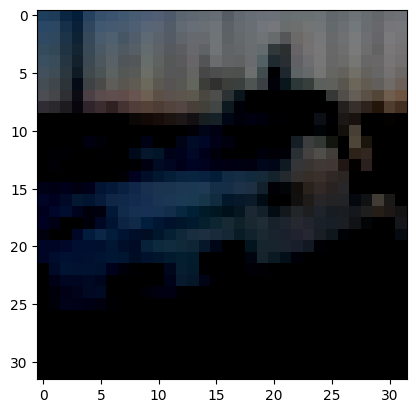

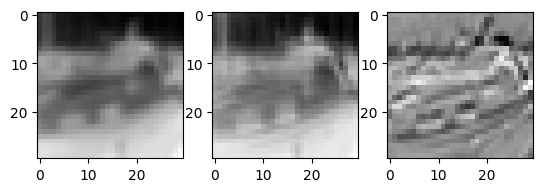

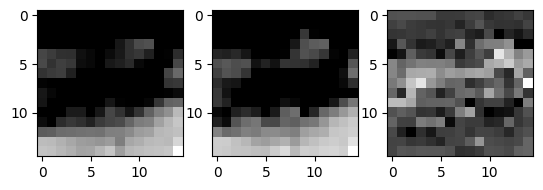

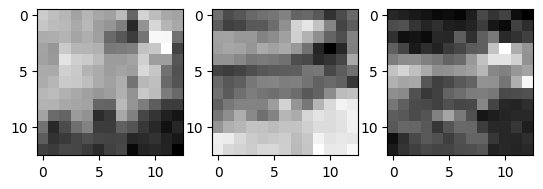

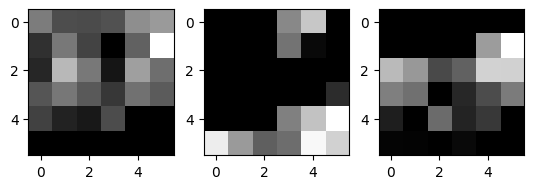

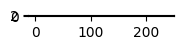

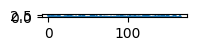

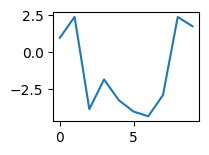

In [143]:
image_tensor = test_set[2][0]
image = image_tensor.unsqueeze(0)
image = image[0]/2 
image = np.transpose(image.numpy(), (1, 2, 0))
plt.imshow(image)
plt.show()

# gets the pics after each layer
_, pics = variantCNN(image_tensor.unsqueeze(0).to(device))

# plot the pics
for i, pics in enumerate(pics):
    try:
        for j in range(3):
            plt.subplot(1, 3, j+1)
            plt.imshow(pics[0, j].cpu().detach().numpy(), cmap='gray')
        plt.show()
    except:
        plt.plot(pics[0].cpu().detach().numpy())
        plt.show()

Efetivamente, o plot dessas imagens nos permite observar de que forma a rede neural convolucional está processando as imagens. Em particular, é possível observar que as imagens estão sendo processadas de forma a destacar as bordas e os contornos, o que é esperado de uma rede neural convolucional. Além disso, é interessante notar as diferenças de plot entre as camadas convolucionais e de pooling em relação às camadas lineares.

# Exercício de "papel e caneta"

**1.** Na aula discutimos como CNNs podem ser vistas como casos especiais de MLPs. Com isso em mente, mostre que i) camadas convolucionais podem ser escritas como uma transformação linear seguida por uma transformação não linear; e ii) camadas de pooling de média ou soma podem ser escritas como transformações lineares.

#### **Resposta (1)**

Vamos mostrar a primeira sentença, que afirma que **(i) camadas convolucionais podem ser escritas como uma transformação linear seguida por uma transformação não linear**. Sabemos, pelo capítulo 9 do Deep Learning Book, que $S(i, j) = (I \star K)(i, i) = \sum_m \sum_n I (m, n) K(i-m, j-n)$. Naturalmente, como estamos simplesmente combinando as entradas de $I$, trata-se de uma combinação linear. Nesse caso, $I$ é a entrada e K é o kernel, ambos bidimensionais. Daí precisamos aplicar uma função não linear, que é a função de ativação. Como observamos nas notas de aula, costumamos utilizar a Rectified Linear Unit (ReLU) nestes casos. De qualquer modo, perceba que a camada convolucional é uma transformação linear seguida de uma transformação não linear, mais especificamente:

$$\text{camada convolucional} = \sigma(S(i, j))$$

Agora, vamos mostrar a segunda sentença, que afirma que **(ii) camadas de pooling de média ou soma podem ser escritas como transformações lineares**. Considerando a transformação linear $y = \mathbf{W} i$, sendo i a entrada e W a matriz de pesos, fica claro que podemos escrever a camada de pooling como uma transformação linear. Mais especificamente, quando W é uma matriz de uns, temos que $y = \mathbf{W} i = \mathbf{1} i = \sum_i i$, que é a soma dos elementos da entrada. Quando W é uma matriz de $1/n$, temos que $y = \mathbf{W} i = \mathbf{1}/n i = \sum_i i/n$, que é a média dos elementos da entrada.

**2.** Criar modelos invariantes a transformações específicas das suas entradas é um tópico quente em machine learning. Por exemplo, suponha que queremos prever propriedades de um grafo $G$ de $n$ nós, com matriz de adjacência $A \in \{0,1\}^{n \times n}$ e em que cada nó $i=1,\ldots,n$ é anotado com um vetor de features $x_i \in \mathbb{R}^d$. Deixe ainda que $X = [x_1, \ldots, x_n]^\intercal$. Note também que um grafo com features de nó pode ser descrito como uma tupla $(X, A)$ sem perda de generalidade. Nesse caso, gostaríamos que nossa rede neural $f$ produzisse o mesmo output para grafos identicos (i.e., fosse invariante a isomorfismo). Dizemos que dois grafos $G=(X, A)$ e $G^\prime=(X^\prime, A^\prime)$ são isomorfos se existe uma matriz de permutação $P \in \{0,1\}^{n \times n} : \forall_i \sum_i P_{ij} = 1, \forall_j P_{ij} = 1 $ tal que $X^\prime = P X$ e $A^\prime = P A P^\intercal$.

Existem uma classe de redes neurais desenhadas especialmente para serem invariantes a isomorfismo: graph neural networks (GNNs). A mais famosa dessas redes é chamada graph convolutional network (GCN). O funcionamento de uma GCN de $L$ camadas para classificação de propriedades de grafos pode ser descrito como:
\begin{align}
&\hat{y} = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{(L)}_{i:}\right)\\
&H^{(\ell)} = \textrm{ReLU}(\tilde{A}H^{(\ell-1)} W^{(\ell)}) \qquad \forall \ell=1,\ldots,L\\
&H^{(0)} = X
\end{align}
onde $W^{(\ell)} \in \mathbb{R^{d_{\ell-1} \times d_{\ell}}}$ são matrizes de peso, com $d_0 = d$ e $d_L$ sendo o número de classes do nosso problema de classificação. Além disse, $\tilde{A} = D^{-1/2}(A + I)D^{-1/2}$ onde $D$ é uma matriz diagonal com $D_{ii}$ contendo o grau do nó $i$.

Prove que a GCN descrita acima produz o mesmo valor para qualquer grafo isomorfo à $G=(X, A)$.

Se você estiver interessado em aprender o básico sobre GNNs, esse vídeo é um bom começo: https://www.youtube.com/watch?v=8owQBFAHw7E (não é necessário para resolver essa questão).

Dica: Mostre antes que se $P$ é uma matriz de permutação $P^\intercal P = I$.

#### **Resposta (2)**

Para começar a responder a questão, vamos provar que $P^T P = I$ se $P$ é matriz de permutação. Uma matriz de permutação tem como característica fundamental o fato de que cada linha e coluna possui exatamente um elemento igual a 1, enquanto todos os outros são iguais a 0. Para qualquer matriz de permutação, quando multiplicamos $P^T$ por $P$, o resultado é uma matriz simétrica onde cada elemento é o produto escalar entre as linhas de $P^T$ e colunas de $P$. Considerando as notações de entrada $i$ e $j$ para as linhas e colunas, respectivamente, temos que, Se i for diferente de j, isso significa que estamos multiplicando a linha i de $P^T$ pela coluna j de $P$. Nesse caso, a linha i de $P^T$ terá um único elemento 1 na coluna j, e a coluna j de $P$ terá um único elemento 1 em outra linha, diferente de i, resultando em 0. Agora, se i for igual a j, isso significa que estamos multiplicando a linha i de $P^T$ pela coluna i de P --- a linha i de $P^T$ terá um único elemento 1 na coluna i, e a coluna i de $P$ terá um único elemento 1 na linha i, resultando em 1. Portanto, $P^T P = I$.

Agora, vamos provar que a GCN produz o mesmo valor para qualquer grafo isomorfo à $G=(X, A)$. Para isso, vamos considerar que $G^\prime=(X^\prime, A^\prime)$ é um grafo isomorfo à $G=(X, A)$, e que existe uma matriz de permutação $P \in \{0,1\}^{n \times n} : \forall_i \sum_i P_{ij} = 1, \forall_j P_{ij} = 1 $ tal que $X^\prime = P X$ e $A^\prime = P A P^\intercal$. Vamos mostrar que $H^{(\ell)} = H^{\prime(\ell)}$ para qualquer $\ell=1,\ldots,L$.

Precisamos encontrar o formato de $A^\prime$, que entrará na equação do GNC. Nesse caso, temos:

$$
A^\prime = D'^{-1/2} (A^\prime + I) D'^{-1/2}
$$

Usando as matrizes de permutação, obtemos:

$$
A^\prime = D'^{-1/2} (P A P^T + I) D'^{-1/2}
$$

E aplicando a distributiva:

$$
A^\prime = D'^{-1/2} PA P^\intercal D'^{-1/2} + D'^{-1/2} D'^{-1/2}
$$

Por definição, $D'$ é uma permutação de $D$, isto é, $D' = P D P^\intercal$. Substituindo isso na equação anterior, chegamos a:

$$
A^\prime = P D^{-1/2} P^\intercal PA P^\intercal P D^{-1/2} P^\intercal + P D^{-1/2} P^\intercal P D^{-1/2} P^\intercal
$$

Como $P^\intercal P = I$, temos, na verdade:

$$
A^\prime = P D^{-1/2} A D^{-1/2} P^\intercal + P D^{-1/2} D^{-1/2} P^\intercal \\

A^\prime = PD^{-1/2}(A+I) D^{-1/2} P^\intercal \\

A^\prime = P A P^\intercal
$$

Para observar que o resultado é o mesmo para qualquer grafo isomorfo, basta substituir $A^\prime$ na equação do GNC. Observe que é necessário substituir apenas na equação 2:

$$
H^{(\ell)} = \textrm{ReLU}(P A P^\intercal H^{(\ell-1)} W^{(\ell)}) \qquad \forall \ell=1,\ldots,L
$$

Interando uma vez, chegamos ao fato de que $H^{(1)} = \textrm{ReLU}(P A P^\intercal X W^{(1)})$. Substituindo $X^\prime = P X$, observamos que $H'^{(1)} = \textrm{ReLU}(P A X W^{(1)}) = PH^{(1)}$. Efetivamente, como isso vale para qualquer $\ell$, temos que $H^{(\ell)} = PH^{(\ell)}$.

Como sabemos que a matriz P é de permutação, e que essa operação não altera o resultado da soma das linhas, confirmamos que, de fato, $\hat y' = \hat y$. O resultado é o mesmo para qualquer grafo isomorfo.

## **Anotações Pessoais**: *Perceptron Multicamadas*
### **Perceptron de Robsenblatt (uma camada)**

O neurônio recebe estímulos de um vetor $x$ com uma dimensão por "terminação nervosa". O neurônio combina o vetor $x$ com base na importância (peso) de cada dendrito ($x \cdot w$). O neurônio soma um estímulo constante $b$, um nível de energia constante, e aplica uma função de ativação $h: \mathbb{R} \rightarrow \{-1, 1\}$ que define a mensagem de saída do neurônio. $b$ grande diminui a quantidade de estímulos ($x \cdot w$) necessários para ativar o neurônio.

A saída $h(x)$ de um perceptron é definida como:

$$
h(x) = \text{sign}(x_n^T w) = 
\begin{cases} +1 & \text{ se } x \cdot w > 0 \\
-1 & \text{ c. c.} \end{cases}$$

A interpretação geométrica é que $h(x) = 1$ se e somente se o ângulo entre $x$ e $w$ é menor que $90^{\circ}$. No caso de classsificações incorretas para $h(x) = 1$, deslocamos $w$ na direção oposta de $x$ para diminuir o valor de $x \cdot w$. I. e., atualizamos os pesos quando $h(x) = 1$ e $y = -1$ ou quando $h(x) = -1$ e $y = 1$ (quando a classificação está incorreta).

```{python3}
w = 0
for epoch in range(epochs):
    for n in range(N):
        y_n = np.sign(x_n @ w)
        if y_n != y[n]:
            w = w + y[n] * x_n
```

Esse modelo de rede neural, que não combina neurônios de maneira composicional, é limitado na medida em que não consegue aprender funções muito simples como a função XOR. Para resolver esse problema, podemos combinar vários perceptrons em uma rede neural multicamadas.

### **Perceptron Multicamadas**

Podemos aprender os pesos de uma rede neural com mais de uma camada usando gradiente descendente. No caso da proposição de **Hinton**, Cada camada $l$ contém $p_l$ perceptrons paralelos que usam a função de ativação $\text{sigmoid}$. Cada perceptron na camada $l+1$ recebe as saídas da camada anterior $l$ como entrada. A descrição recursiva da saída de um MLP é:

$$
\Psi^{l} (x) = 
\begin{cases}
\phi_l (\Psi^{l-1} (x) W_l) & \text{se } l > 0 \\
x & \text{c. c.}
\end{cases}
$$

onde $\phi_l$ é a função de ativação da camada $l$ e $W_l$ é a matriz de pesos da camada $l$.

Os pesos $W_1, ..., W_L$ são aprendidos usando *backpropagation*. Trata-se de uma técnica de otimização que usa a regra da cadeia para calcular o gradiente da função de perda em relação aos pesos da rede neural. A saída do vetor de entrada $x$ é descrita como:

$$ z^{(l)} = \Psi^{(l)} (x) = \phi_l (... \phi_2(\phi_1(x W_1)W_2)... W_l),$$

de modo que o gradiente da função de perda $L$ em relação aos pesos $W_l$ é:

$$
\dfrac{\partial l (z^{(L)}, y)}{\partial W_j} = 
\dfrac{\partial l (z^{(L)}, y)}{\partial z^{(L)}} \dfrac{\partial z^{(L)}}{\partial z^{(L-1)}} ... \dfrac{\partial z^{(j+1)}}{\partial z^{(j)}} \dfrac{\partial z^{(j)}}{\partial W_j},
$$

para qualquer camada $j > 0$. O importante é observar que a derivada dos pesos de uma camada $j$ depende diretamente das derivadas das camadas subsequentes $j+1, ..., L$. Por isso, o algoritmo computa gradientes em dois passos, o *forward* e o *backward*:

1. *Forward*: propagamos os vetores $x$ de input iterativamente nas camadas, guardando as matrizes de derivadas parciais $\dfrac{\partial z^{(j)}}{\partial z^{(j-1)}}$ e os vetores $\dfrac{z^{(j)}}{\partial W^{(l)}}$ para cada camada $j$. Na última camada, computamos também o gradiente $\dfrac{\partial l (z^{(L)}, y)}{\partial z^{(L)}}$ da função de perda em relação à saída da rede neural.

2. *Backward*: propagamos o gradiente $\dfrac{\partial l (z^{(L)}, y)}{\partial z^{(L)}}$ da última camada iterativamente para as camadas anteriores, usando as matrizes de derivadas parciais.

```
gradPerda = gradientePerda(z^(L), y)
for j = L, ..., 1:
    pesolNew = pesol - taxaAprendizado * gradPerda * dz^(j)/dW^(l)
    if j > 1:
        gradPerda = gradPerda * dz^(j)/dz^(j-1)
```

Como *loss*, normalmente usamos a função de entropia cruzada para classificação binária e a função de erro quadrático para regressão.

O uso de mais de três camadas para treinar redes neurais era uma tarefa desafiadora, particularmente porque a função de ativação $\text{sigmoid}$ possui gradiente próximo de zero, fazendo com que alguns pesos pudessem não ser atualizados. A solução é utilizar ReLU (Rectified Linear Unit) como função de ativação. A função ReLU é definida como $\text{ReLU}(x) = \max(0, x)$.

## **Anotações Pessoais**: *Redes Neurais Convolucionais*

*Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.* (Goodfellow et al., 2016, p. 326).

Convoluções são combinações lineares.

Redes neurais convolucionais tipicamente possuem interações esparsas. Isso ocorre de forma que conseguimos identificar pequenas partes de uma imagem e ignorar o resto. Isso significa que precisamos guardar menos parâmetros, reduzindo o custo computacional em termos de memória e melhorando a eficiência do modelo.